In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nibabel
import nibabel.processing
import os
from skimage.filters import threshold_otsu
import cc3d
import shutil
import pickle
import pandas as pd

In [2]:
1+1

2

In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import tqdm, trange
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
#USE SMALL GPU#
use_gpu = 0 
# The largest memory size GPU is always the first one (0) as they are sorted by size!
gpus=tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[use_gpu], 'GPU')

In [6]:
#Borrowed from the 3D preprocessing

def normalize(volume):
    """Normalize the volume"""
    min = volume.min()
    max = volume.max()
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def pp(original_image):
    
    input_img=input_img = nibabel.load("{0}".format(original_image))
    resampled_img = nibabel.processing.conform(input_img, out_shape=(100,100,90), voxel_size=(2.0, 2.0, 2.0))
    
    img = resampled_img.get_fdata()
    
    thresh = threshold_otsu(img)
    bw_img1 = np.copy(img)
    bw_img1[bw_img1 < thresh] = 0
    bw_img1[bw_img1 >= thresh] = 255
    
    input_CCA=bw_img1.astype('int32')
    connectivity = 6
    labels_out, N = cc3d.connected_components(input_CCA, return_N=True)
    
    def mask_largest_label (labels_out, N):
        #print("This function returns the largest blob of a CCA processed image as a binary mask")
        #print("")
        def separate_labels(label_ID, label_matrix):
            mask=1*(label_matrix == label_ID)
            return mask
        labellist=[]
        for j in range(1, N+1):
            a=separate_labels(j, labels_out)
            labellist.append(a)
        #print("The image has {0} labels".format(len(labellist)))
        z=labellist[0]
        #print("The shape of the labels is: {0}".format(z.shape))
        sizelist=[]
        for counter,element in enumerate (labellist):
            a=labellist[counter].sum()
            sizelist.append(a)
        #print("Label sizes: {0}".format(sizelist))
        sizelist=np.asarray(sizelist)
        a=sizelist.argmax()
        #print("The largest label index is: {0}".format(a))
        mask=labellist[a]
        #print("The largest label is now a binary mask with shape {0}, size {1}, max value {2} and min value {3}".format((mask.shape),(mask.sum()),(mask.max()),(mask.min())))
        return mask

    mask=mask_largest_label(labels_out, N)
    
    pimg=np.multiply(img,mask)
    
    return pimg

def process(path):
    """Read and normalize volume"""
    # Read and pp scan
    volume = pp(path)
    # Normalize
    volume = normalize(volume)
    #Prepare for NN input
    volume = np.expand_dims(volume, axis=0)
    volume = np.expand_dims(volume, axis=4)
    return volume

In [ ]:
"""The function takes the directory of the saved model, the directory of the images to test and the directory that
contains only the class of interest, i.e. the 1 output of the model (as a ground truth). It plots ROC, Confusion
Matrix, Precission Recall and returns classification metrics

In [7]:
def get_metrics(modeldir,directory,grounddir, thresh=0.5):
    model=tf.keras.models.load_model(modeldir)
    dire=directory
    
    predictdict={}
    for i in tqdm(os.listdir(dire), desc='Prediction making'):
        volume=process(os.path.join(dire,'{}'.format(i)))
        prediction=model.predict(volume)
        predictdict.update({'{}'.format(i): float(prediction)})
    pdpred=pd.DataFrame.from_dict(data=predictdict, orient="index", columns=["pred"])
    
    plist=pdpred.index
    groundt=os.listdir(grounddir)
    grounddict={}
    for i in plist:
        if i in groundt:
            grounddict.update({'{}'.format(i): 1})
        else:
            grounddict.update({'{}'.format(i): 0})
    pdground=pd.DataFrame.from_dict(data=grounddict, orient="index", columns=["ground_truth"])
    
    preddict={}
    for i in plist:
        if pdpred["pred"][i] >thresh:
            preddict.update({'{}'.format(i): 1})
        else:
            preddict.update({'{}'.format(i): 0})
    pdlab=pd.DataFrame.from_dict(data=preddict, orient="index", columns=["pred_label"])
    
    pdf=pd.concat([pdpred,pdground], axis=1)
    pdf=pd.concat([pdf,pdlab], axis=1)       
    
    auc=roc_auc_score(pdf["ground_truth"], pdf["pred"])
    print("Area under ROC curve is: ",auc)
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(pdf["ground_truth"], pdf["pred"], drop_intermediate=True)
    # calculate the g-mean for each threshold
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    # plot the roc curve for the model
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Model(AUC=%.2f)' % auc)
    #pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.title("Receiver-Operating-Characteristic curve")
    pyplot.show()
    print('S-E Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    print("Accuracy: ",accuracy_score(pdf["ground_truth"], pdf["pred_label"]))
    tn, fp, fn, tp = confusion_matrix(pdf["ground_truth"], pdf["pred_label"]).ravel()
    sens=tp/(tp+fn)
    print("Sensitivity: ",sens)
    spec=tn/(fp+tn)
    print("Specificity: ", spec)
    tpv=tp/(tp+fp)
    print("PPV: ", tpv)
    fpv=tn/(fn+tn)
    print("NPV: ", fpv)
    
    # calculate pr curves
    precision, recall, thresholds = precision_recall_curve(pdf["ground_truth"], pdf["pred"])
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    # plot the pr curve for the model
    pyplot.plot(recall, precision, marker='.', label='Model')
    pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    # show the plot
    pyplot.title("Precision-Recall curve")
    pyplot.show()
    print('S-TPV Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    
    cm = confusion_matrix(pdf["ground_truth"], pdf["pred_label"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    pyplot.title("Confusion Matrix of {} patients in test set".format(len(plist)))
    pyplot.show()
    
    return auc, sens, spec, tpv, fpv

In [ ]:
"""Below you can see all models, THE MODELS USED IN THE PAPER ARE (## AD/Control Small CNN )
and (# MCI to AD, 5 Fold validation. Updated conv, Small CNN)

## AD/Control Small CNN

In [8]:
modeldir="saved_models/3d_g_tuned/epoch29"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/split/test/wholetest"
grounddir="pdata/newdata/split/test/ad"

Prediction making:   0%|          | 0/117 [00:00<?, ?it/s]

Area under ROC curve is:  0.9506599622878693


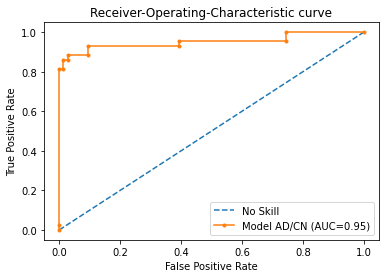

S-E Best Threshold=0.498724, G-Mean=0.927
Accuracy:  0.9316239316239316
Sensitivity:  0.8604651162790697
Specificity:  0.972972972972973
PPV:  0.9487179487179487
NPV:  0.9230769230769231


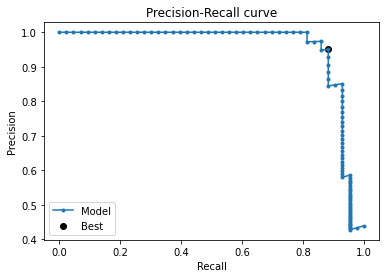

S-TPV Best Threshold=0.498724, F-Score=0.916


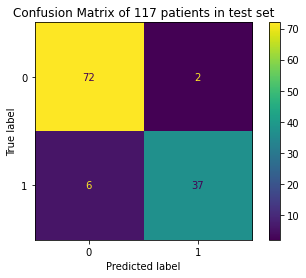

(0.9506599622878693,
 0.8604651162790697,
 0.972972972972973,
 0.9487179487179487,
 0.9230769230769231)

In [9]:
get_metrics(modeldir,directory,grounddir)

## AD / Control Small CNN replication

In [114]:
modeldir="saved_models/reproducing_b_simplecnn2/epoch28"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/split/test/wholetest"
grounddir="pdata/newdata/split/test/ad"

Prediction making:   0%|          | 0/117 [00:00<?, ?it/s]

Area under ROC curve is:  0.9490886235072281


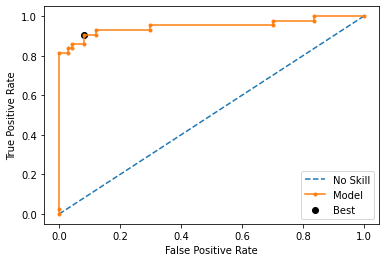

S-E Best Threshold=0.376234, G-Mean=0.913
Accuracy:  0.9145299145299145
Sensitivity:  0.8372093023255814
Specificity:  0.9594594594594594
PPV:  0.9230769230769231
NPV:  0.9102564102564102


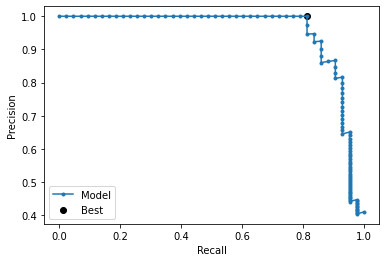

S-TPV Best Threshold=0.713292, F-Score=0.897


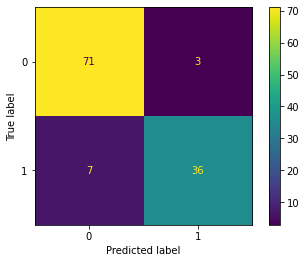

In [115]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/117 [00:00<?, ?it/s]

Area under ROC curve is:  0.9490886235072281


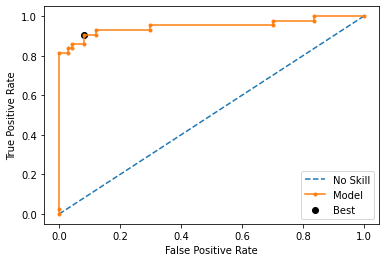

S-E Best Threshold=0.376234, G-Mean=0.913
Accuracy:  0.9230769230769231
Sensitivity:  0.7906976744186046
Specificity:  1.0
TPV:  1.0
FPV:  0.891566265060241


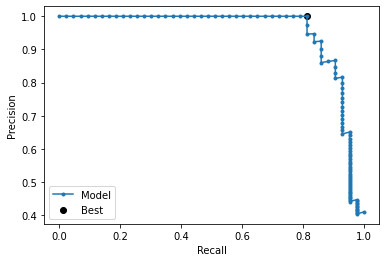

S-TPV Best Threshold=0.713292, F-Score=0.897


In [35]:
get_metrics(modeldir,directory,grounddir, thresh=0.713292)

Prediction making:   0%|          | 0/117 [00:00<?, ?it/s]

Area under ROC curve is:  0.9490886235072281


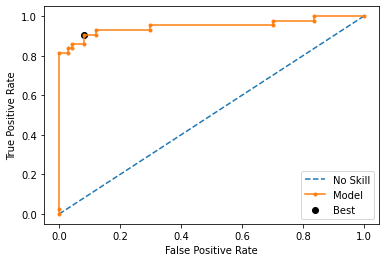

S-E Best Threshold=0.376234, G-Mean=0.913
Accuracy:  0.9145299145299145
Sensitivity:  0.9069767441860465
Specificity:  0.918918918918919
PPV:  0.8666666666666667
NPV:  0.9444444444444444


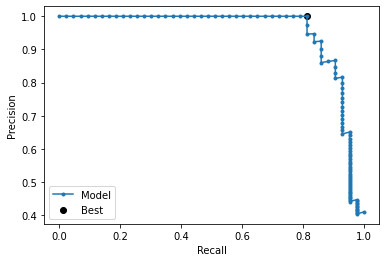

S-TPV Best Threshold=0.713292, F-Score=0.897


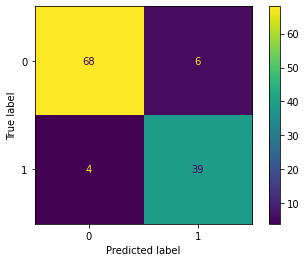

In [116]:
get_metrics(modeldir,directory,grounddir,0.376234)

# MCI to AD, AD/Control model

In [46]:
modeldir="saved_models/3d_g_tuned/epoch29"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/mcisplit/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/mcisplit/pMCI"

Prediction making:   0%|          | 0/373 [00:00<?, ?it/s]

Area under ROC curve is:  0.7606122103838998


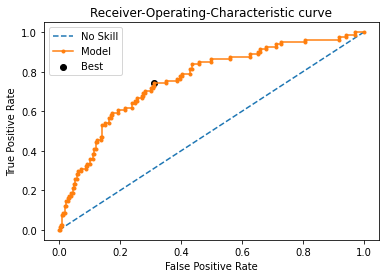

S-E Best Threshold=0.450869, G-Mean=0.714
Accuracy:  0.7131367292225201
Sensitivity:  0.7037037037037037
Specificity:  0.7157534246575342
PPV:  0.40714285714285714
NPV:  0.8969957081545065


<ipython-input-43-1955c3eac942>:67: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


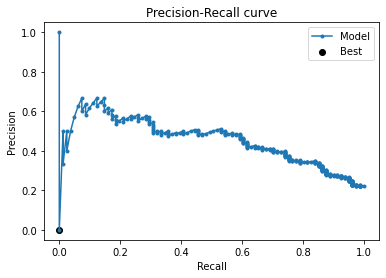

S-TPV Best Threshold=0.999846, F-Score=nan


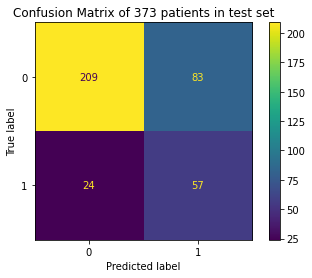

In [47]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/373 [00:00<?, ?it/s]

Area under ROC curve is:  0.7606122103838998


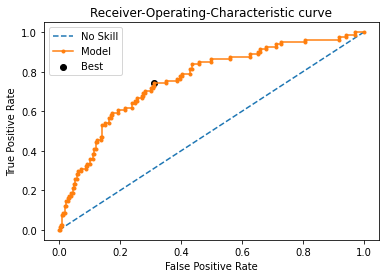

S-E Best Threshold=0.450869, G-Mean=0.714
Accuracy:  0.6997319034852547
Sensitivity:  0.7407407407407407
Specificity:  0.6883561643835616
PPV:  0.3973509933774834
NPV:  0.9054054054054054


<ipython-input-43-1955c3eac942>:67: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


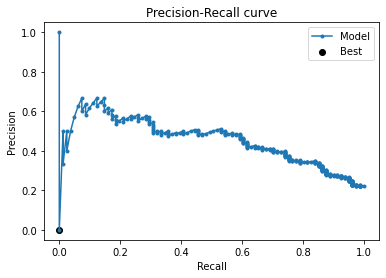

S-TPV Best Threshold=0.999846, F-Score=nan


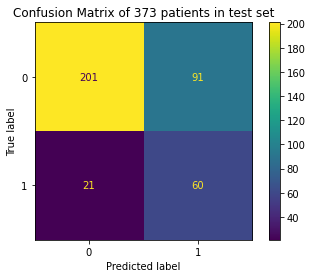

In [48]:
get_metrics(modeldir,directory,grounddir,0.450869)

# MCI to AD, 5 Fold validation. Original Small CNN

In [74]:
print("Mean AUC over 5 folds: ",((90.08+93.53+79.84+80.17+84.21)/5))
print("Mean Sensitivity over 5 folds: ",((87.5+93.75+93.75+87.5+76.47)/5))
print("Mean Specificity over 5 folds: ", ((82.75+82.75+56.89+65.51+81.66)/5))
print("Mean PPV over 5 folds: ",((58.33+60+37.5+41.17+54.16)/5))
print("Mean NPV over 5 folds: ", ((96+97.95+97+95+92.45)/5))

Mean AUC over 5 folds:  85.566
Mean Sensitivity over 5 folds:  87.79400000000001
Mean Specificity over 5 folds:  73.91199999999999
Mean TPV over 5 folds:  50.232
Mean FPV over 5 folds:  95.67999999999999


## Fold 1

In [10]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/smallcnnfold0/epoch24"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold1/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold1/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9008620689655172


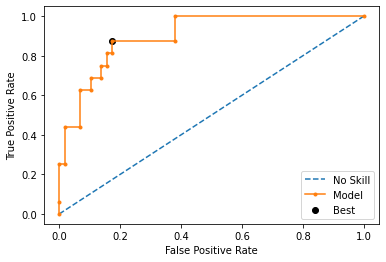

S-E Best Threshold=0.432546, G-Mean=0.851
Accuracy:  0.8378378378378378
Sensitivity:  0.6875
Specificity:  0.8793103448275862
TPV:  0.6111111111111112
FPV:  0.9107142857142857


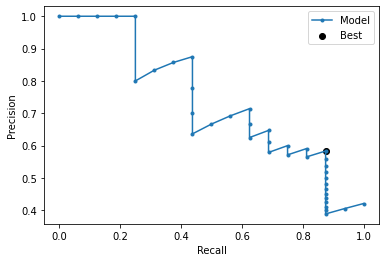

S-TPV Best Threshold=0.432546, F-Score=0.700


In [49]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9008620689655172


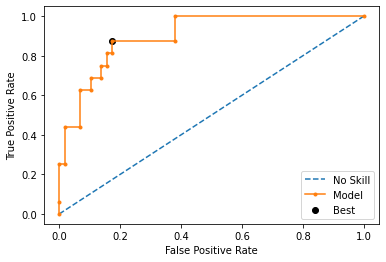

S-E Best Threshold=0.432546, G-Mean=0.851
Accuracy:  0.8378378378378378
Sensitivity:  0.875
Specificity:  0.8275862068965517
PPV:  0.5833333333333334
NPV:  0.96


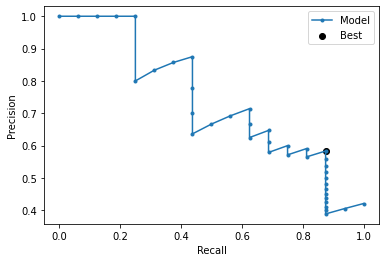

S-TPV Best Threshold=0.432546, F-Score=0.700


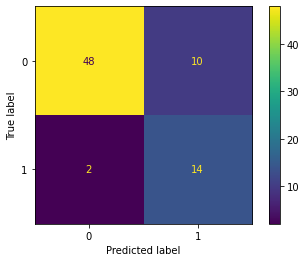

In [11]:
get_metrics(modeldir,directory,grounddir,0.432546)

## Fold 2

In [12]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/smallcnnfold1/epoch36"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold2/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold2/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9353448275862069


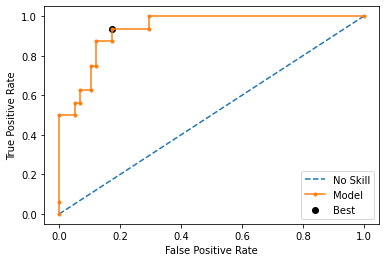

S-E Best Threshold=0.425793, G-Mean=0.881
Accuracy:  0.8513513513513513
Sensitivity:  0.75
Specificity:  0.8793103448275862
TPV:  0.631578947368421
FPV:  0.9272727272727272


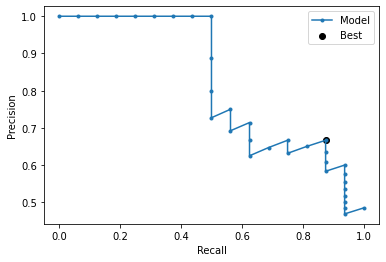

S-TPV Best Threshold=0.470099, F-Score=0.757


In [51]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9353448275862069


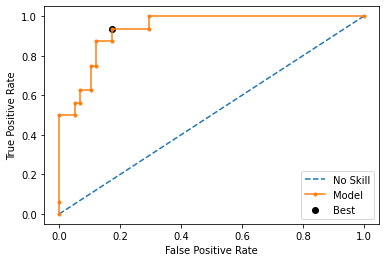

S-E Best Threshold=0.425793, G-Mean=0.881
Accuracy:  0.8513513513513513
Sensitivity:  0.9375
Specificity:  0.8275862068965517
PPV:  0.6
NPV:  0.9795918367346939


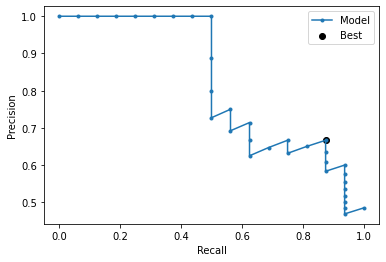

S-TPV Best Threshold=0.470099, F-Score=0.757


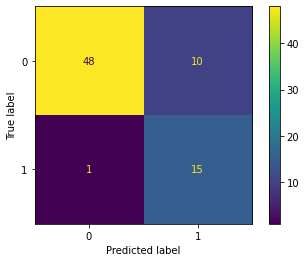

In [13]:
get_metrics(modeldir,directory,grounddir,0.425793)

## Fold 3

In [14]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/smallcnnfold2/epoch27"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold3/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold3/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.7984913793103449


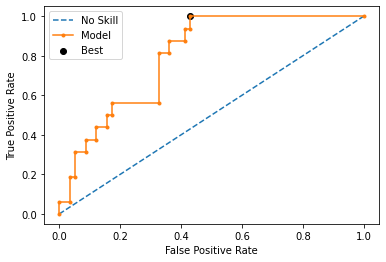

S-E Best Threshold=0.198688, G-Mean=0.754
Accuracy:  0.7702702702702703
Sensitivity:  0.5
Specificity:  0.8448275862068966
TPV:  0.47058823529411764
FPV:  0.8596491228070176


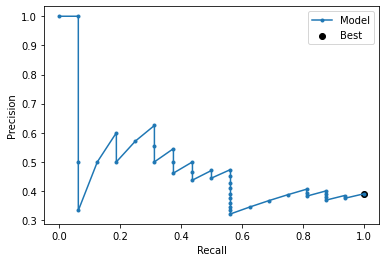

S-TPV Best Threshold=0.198688, F-Score=0.561


In [58]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.7984913793103449


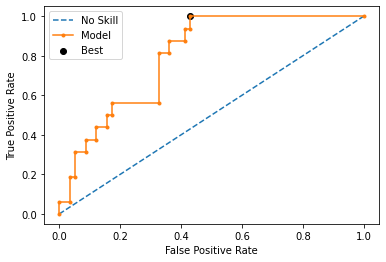

S-E Best Threshold=0.198688, G-Mean=0.754
Accuracy:  0.6486486486486487
Sensitivity:  0.9375
Specificity:  0.5689655172413793
PPV:  0.375
NPV:  0.9705882352941176


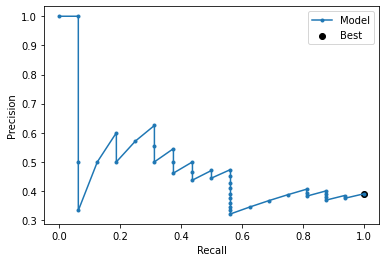

S-TPV Best Threshold=0.198688, F-Score=0.561


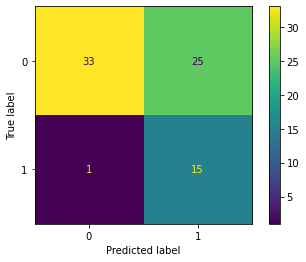

In [15]:
get_metrics(modeldir,directory,grounddir,0.198688)

## Fold 4

In [16]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/smallcnnfold3/epoch49"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold4/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold4/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8017241379310345


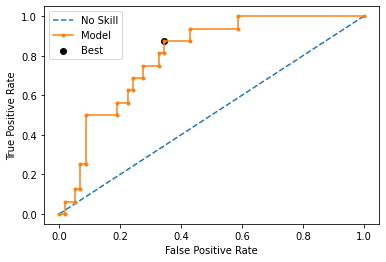

S-E Best Threshold=0.186590, G-Mean=0.757
Accuracy:  0.7702702702702703
Sensitivity:  0.5
Specificity:  0.8448275862068966
TPV:  0.47058823529411764
FPV:  0.8596491228070176


<ipython-input-34-ae4d698c0583>:66: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


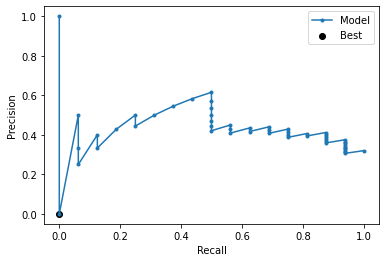

S-TPV Best Threshold=0.961590, F-Score=nan


In [60]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8017241379310345


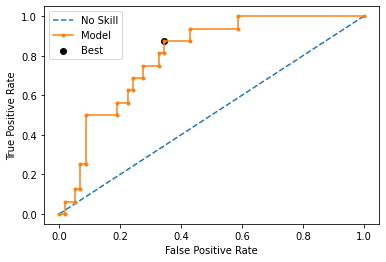

S-E Best Threshold=0.186590, G-Mean=0.757
Accuracy:  0.7027027027027027
Sensitivity:  0.875
Specificity:  0.6551724137931034
PPV:  0.4117647058823529
NPV:  0.95


<ipython-input-8-e11804f7b8be>:66: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


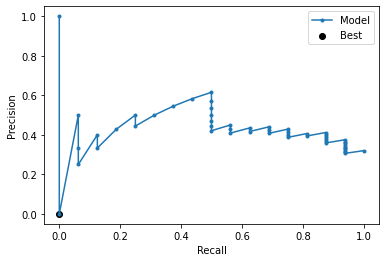

S-TPV Best Threshold=0.961590, F-Score=nan


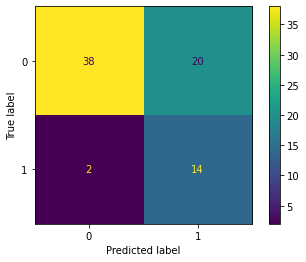

In [17]:
get_metrics(modeldir,directory,grounddir,0.186590)

## Fold 5

In [18]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/smallcnnfold4/epoch20"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold5/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold5/pMCI"

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.842156862745098


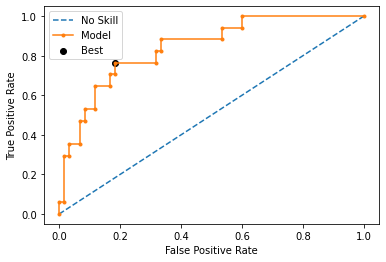

S-E Best Threshold=0.328356, G-Mean=0.790
Accuracy:  0.8181818181818182
Sensitivity:  0.5294117647058824
Specificity:  0.9
TPV:  0.6
FPV:  0.8709677419354839


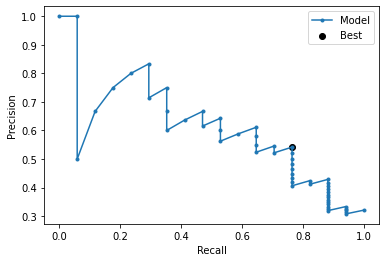

S-TPV Best Threshold=0.328356, F-Score=0.634


In [62]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.842156862745098


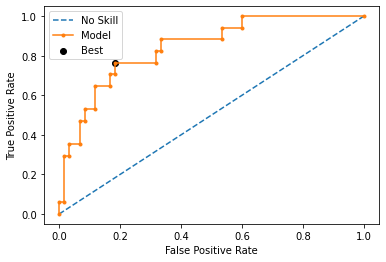

S-E Best Threshold=0.328356, G-Mean=0.790
Accuracy:  0.8051948051948052
Sensitivity:  0.7647058823529411
Specificity:  0.8166666666666667
PPV:  0.5416666666666666
NPV:  0.9245283018867925


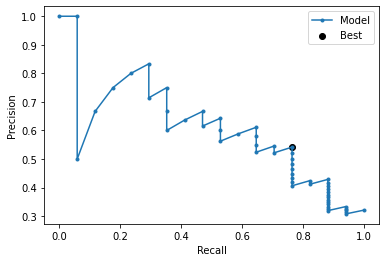

S-TPV Best Threshold=0.328356, F-Score=0.634


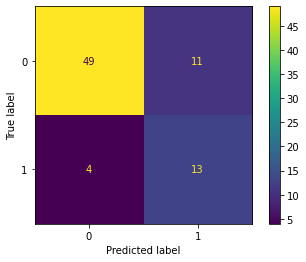

In [19]:
get_metrics(modeldir,directory,grounddir,0.328356)

# MCI to AD, 5 Fold validation. Replicated Small CNN

In [101]:
print("Mean AUC over 5 folds: ",((90.94+91.48+77.37+80.38+77.54)/5))
print("Mean Sensitivity over 5 folds: ",((81.25+87.5+75+81.25+70.58)/5))
print("Mean Specificity over 5 folds: ", ((86.20+82.75+62.06+77.58+80)/5))
print("Mean PPV over 5 folds: ",((61.9+58.33+35.29+50+50)/5))
print("Mean NPV over 5 folds: ", ((94.33+96+90+93.75+90.56)/5))

Mean AUC over 5 folds:  83.542
Mean Sensitivity over 5 folds:  79.116
Mean Specificity over 5 folds:  77.71799999999999
Mean TPV over 5 folds:  51.104
Mean FPV over 5 folds:  92.928


## Fold 1

In [86]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/rep2_smallcnnfold0/epoch28"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold1/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold1/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9094827586206896


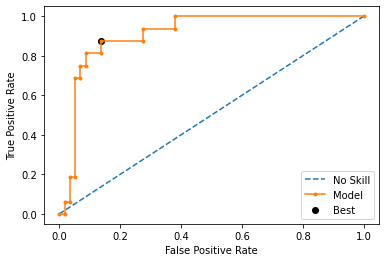

S-E Best Threshold=0.336218, G-Mean=0.869
Accuracy:  0.8783783783783784
Sensitivity:  0.625
Specificity:  0.9482758620689655
TPV:  0.7692307692307693
FPV:  0.9016393442622951


<ipython-input-34-ae4d698c0583>:66: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


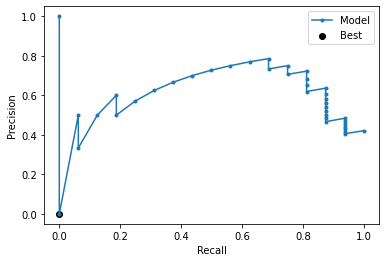

S-TPV Best Threshold=0.767680, F-Score=nan


In [76]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9094827586206896


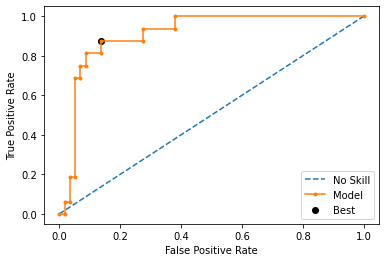

S-E Best Threshold=0.336218, G-Mean=0.869
Accuracy:  0.8513513513513513
Sensitivity:  0.8125
Specificity:  0.8620689655172413
TPV:  0.6190476190476191
FPV:  0.9433962264150944


<ipython-input-34-ae4d698c0583>:66: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


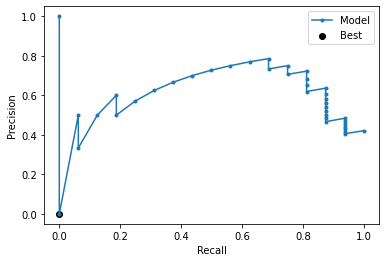

S-TPV Best Threshold=0.767680, F-Score=nan


In [87]:
get_metrics(modeldir,directory,grounddir,0.336218)

## Fold 2

In [88]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/rep2_smallcnnfold1/epoch17"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold2/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold2/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9148706896551725


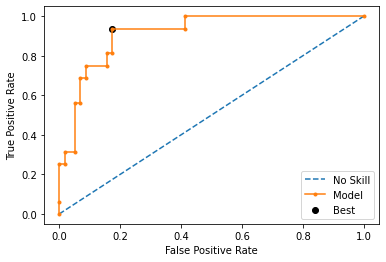

S-E Best Threshold=0.326146, G-Mean=0.881
Accuracy:  0.8783783783783784
Sensitivity:  0.75
Specificity:  0.9137931034482759
TPV:  0.7058823529411765
FPV:  0.9298245614035088


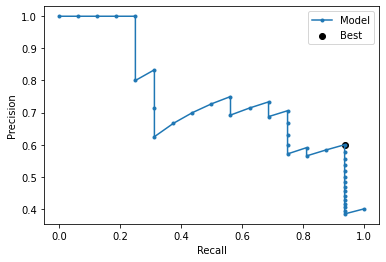

S-TPV Best Threshold=0.326146, F-Score=0.732


In [78]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9148706896551725


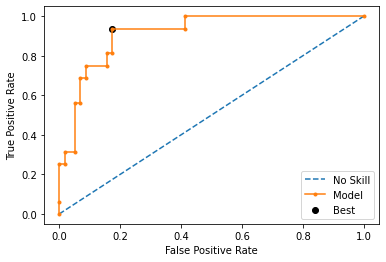

S-E Best Threshold=0.326146, G-Mean=0.881
Accuracy:  0.8378378378378378
Sensitivity:  0.875
Specificity:  0.8275862068965517
TPV:  0.5833333333333334
FPV:  0.96


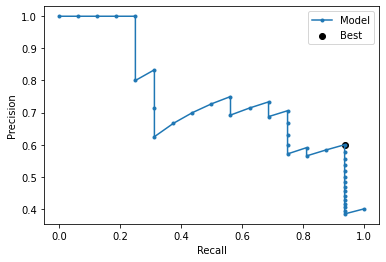

S-TPV Best Threshold=0.326146, F-Score=0.732


In [89]:
get_metrics(modeldir,directory,grounddir,0.326146)

## Fold 3

In [90]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/rep2_smallcnnfold2/epoch12"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold3/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold3/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.7737068965517242


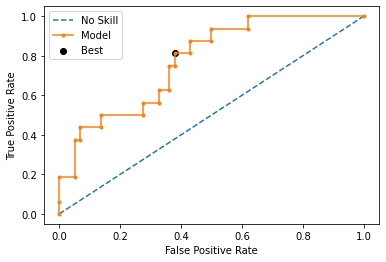

S-E Best Threshold=0.137152, G-Mean=0.710
Accuracy:  0.7837837837837838
Sensitivity:  0.4375
Specificity:  0.8793103448275862
TPV:  0.5
FPV:  0.85


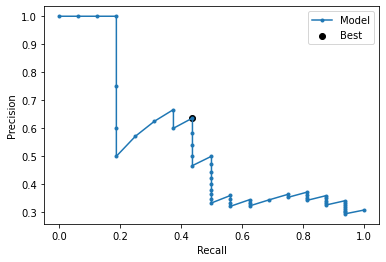

S-TPV Best Threshold=0.555299, F-Score=0.519


In [80]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.7737068965517242


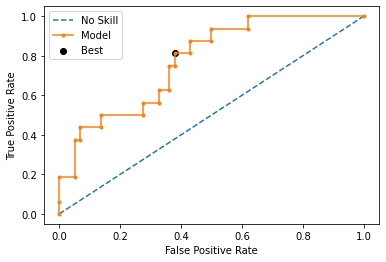

S-E Best Threshold=0.137152, G-Mean=0.710
Accuracy:  0.6486486486486487
Sensitivity:  0.75
Specificity:  0.6206896551724138
TPV:  0.35294117647058826
FPV:  0.9


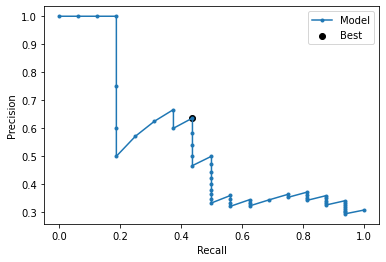

S-TPV Best Threshold=0.555299, F-Score=0.519


In [91]:
get_metrics(modeldir,directory,grounddir,0.137152)

## Fold 4

In [92]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/rep2_smallcnnfold3/epoch38"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold4/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold4/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8038793103448275


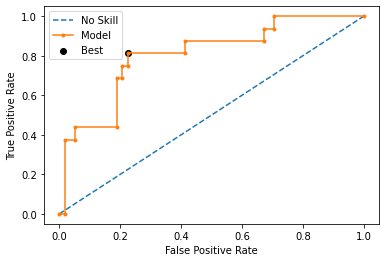

S-E Best Threshold=0.235930, G-Mean=0.794
Accuracy:  0.8243243243243243
Sensitivity:  0.4375
Specificity:  0.9310344827586207
TPV:  0.6363636363636364
FPV:  0.8571428571428571


<ipython-input-34-ae4d698c0583>:66: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


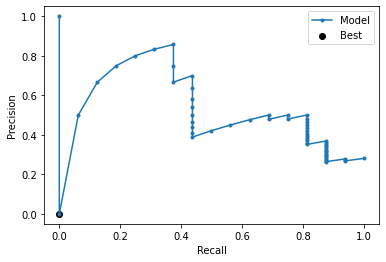

S-TPV Best Threshold=0.896046, F-Score=nan


In [82]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8038793103448275


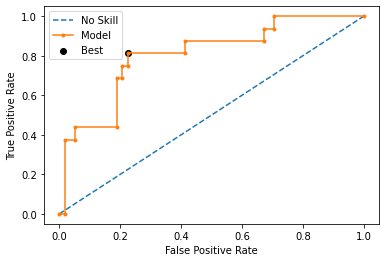

S-E Best Threshold=0.235930, G-Mean=0.794
Accuracy:  0.7837837837837838
Sensitivity:  0.8125
Specificity:  0.7758620689655172
TPV:  0.5
FPV:  0.9375


<ipython-input-34-ae4d698c0583>:66: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


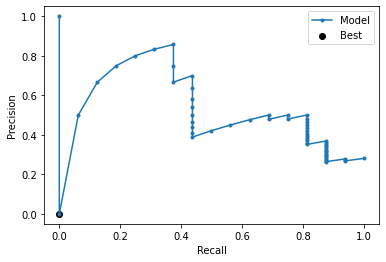

S-TPV Best Threshold=0.896046, F-Score=nan


In [93]:
get_metrics(modeldir,directory,grounddir,0.235930)

## Fold 5

In [94]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/rep2_smallcnnfold4/epoch8"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold5/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold5/pMCI"

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.7754901960784314


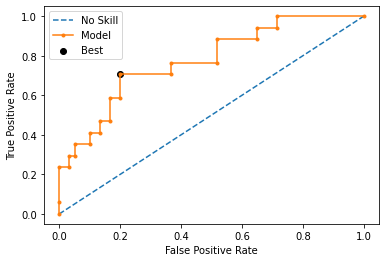

S-E Best Threshold=0.234387, G-Mean=0.751
Accuracy:  0.7922077922077922
Sensitivity:  0.4117647058823529
Specificity:  0.9
TPV:  0.5384615384615384
FPV:  0.84375


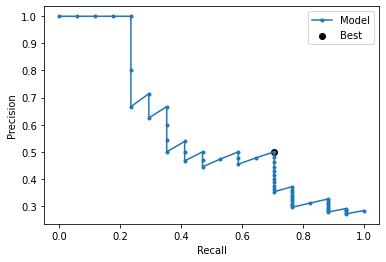

S-TPV Best Threshold=0.234387, F-Score=0.585


In [84]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.7754901960784314


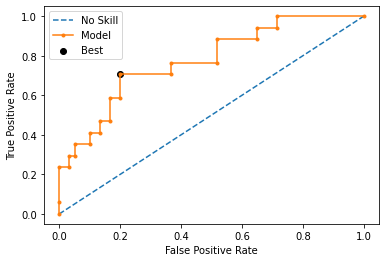

S-E Best Threshold=0.234387, G-Mean=0.751
Accuracy:  0.7792207792207793
Sensitivity:  0.7058823529411765
Specificity:  0.8
PPV:  0.5
NPV:  0.9056603773584906


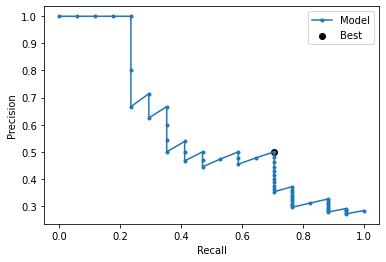

S-TPV Best Threshold=0.234387, F-Score=0.585


In [103]:
get_metrics(modeldir,directory,grounddir,0.234387)

# MCI to AD, 5 Fold validation. Fine tuned big CNN

In [7]:
print("Mean AUC over 5 folds: ",((91.11+91.70+80.81+84.91+80.88)/5))
print("Mean Sensitivity over 5 folds: ",((75+68.75+93.75+75+70.58)/5))
print("Mean Specificity over 5 folds: ", ((91.3+91.5+65.51+81.03+75)/5))
print("Mean PPV over 5 folds: ",((70.58+73.3+42.85+52.17+44.4)/5))
print("Mean NPV over 5 folds: ", ((92.98+91.52+97.43+92.15+90)/5))

Mean AUC over 5 folds:  85.88199999999999
Mean Sensitivity over 5 folds:  76.616
Mean Specificity over 5 folds:  80.86800000000001
Mean PPV over 5 folds:  56.65999999999999
Mean NPV over 5 folds:  92.816


## Fold 1

In [30]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/ftbigcnnfold0/epoch22"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold1/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold1/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9116379310344829


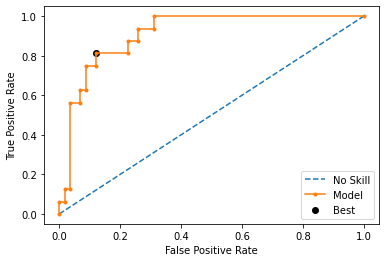

S-E Best Threshold=0.379151, G-Mean=0.845
Accuracy:  0.8648648648648649
Sensitivity:  0.625
Specificity:  0.9310344827586207
PPV:  0.7142857142857143
NPV:  0.9


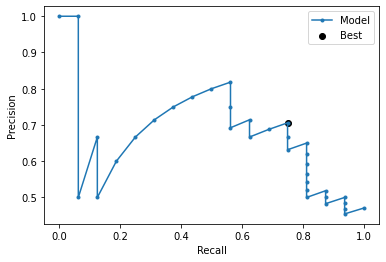

S-TPV Best Threshold=0.427725, F-Score=0.727


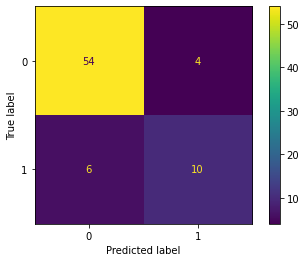

In [21]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9116379310344829


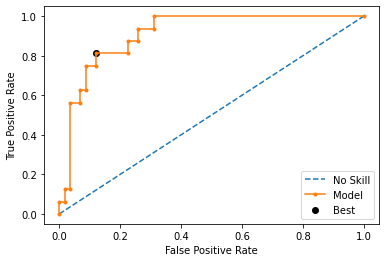

S-E Best Threshold=0.379151, G-Mean=0.845
Accuracy:  0.8783783783783784
Sensitivity:  0.75
Specificity:  0.9137931034482759
PPV:  0.7058823529411765
NPV:  0.9298245614035088


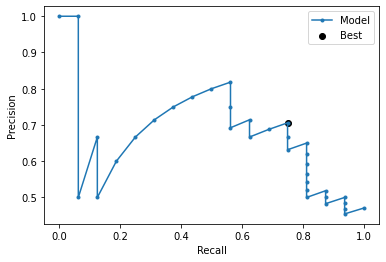

S-TPV Best Threshold=0.427725, F-Score=0.727


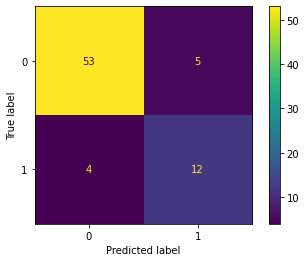

In [31]:
get_metrics(modeldir,directory,grounddir,0.427725)

## Fold 2

In [32]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/ftbigcnnfold1/epoch28"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold2/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold2/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9170258620689655


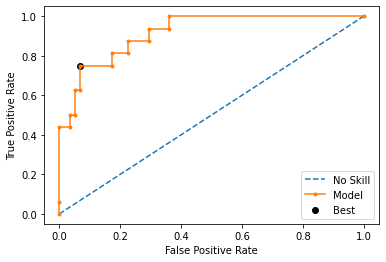

S-E Best Threshold=0.442574, G-Mean=0.836
Accuracy:  0.8648648648648649
Sensitivity:  0.625
Specificity:  0.9310344827586207
PPV:  0.7142857142857143
NPV:  0.9


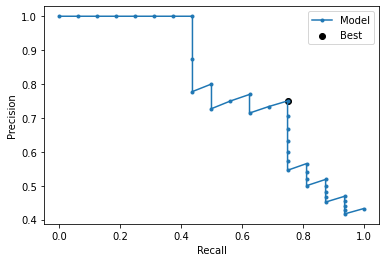

S-TPV Best Threshold=0.442574, F-Score=0.750


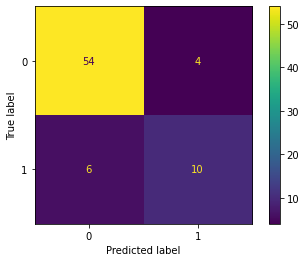

In [23]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.9170258620689655


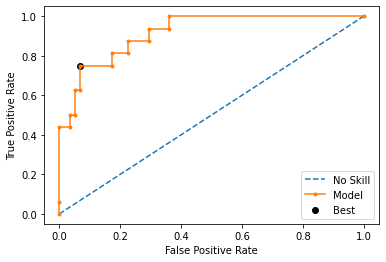

S-E Best Threshold=0.442574, G-Mean=0.836
Accuracy:  0.8783783783783784
Sensitivity:  0.6875
Specificity:  0.9310344827586207
PPV:  0.7333333333333333
NPV:  0.9152542372881356


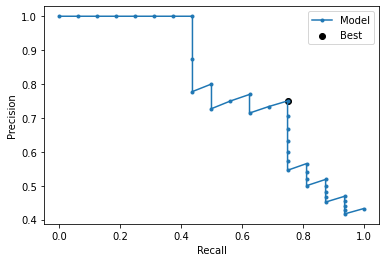

S-TPV Best Threshold=0.442574, F-Score=0.750


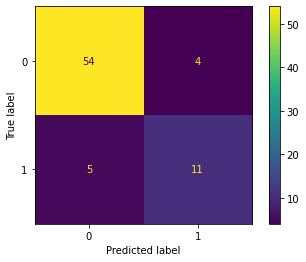

In [33]:
get_metrics(modeldir,directory,grounddir,0.442574)

## Fold 3

In [34]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/ftbigcnnfold2/epoch17"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold3/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold3/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8081896551724139


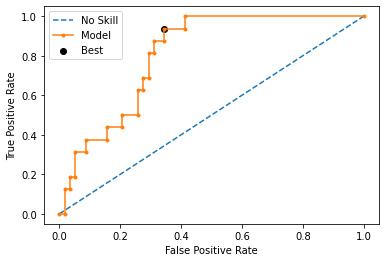

S-E Best Threshold=0.207408, G-Mean=0.784
Accuracy:  0.7432432432432432
Sensitivity:  0.375
Specificity:  0.8448275862068966
PPV:  0.4
NPV:  0.8305084745762712


<ipython-input-8-e11804f7b8be>:66: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


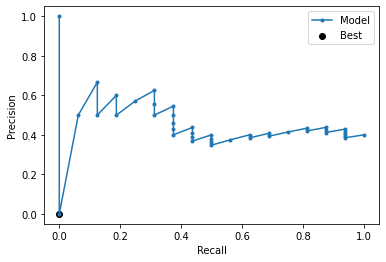

S-TPV Best Threshold=0.869070, F-Score=nan


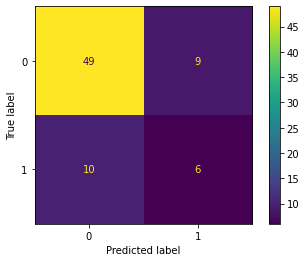

In [25]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8081896551724139


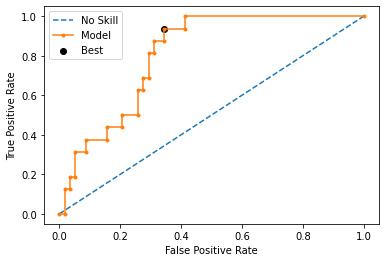

S-E Best Threshold=0.207408, G-Mean=0.784
Accuracy:  0.7162162162162162
Sensitivity:  0.9375
Specificity:  0.6551724137931034
PPV:  0.42857142857142855
NPV:  0.9743589743589743


<ipython-input-8-e11804f7b8be>:66: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


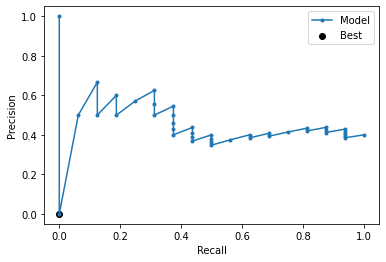

S-TPV Best Threshold=0.869070, F-Score=nan


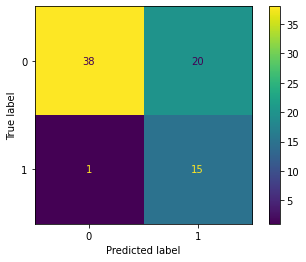

In [35]:
get_metrics(modeldir,directory,grounddir,0.207408)

## Fold 4

In [36]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/ftbigcnnfold3/epoch36"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold4/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold4/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8491379310344828


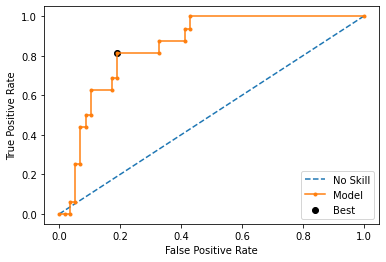

S-E Best Threshold=0.238154, G-Mean=0.811
Accuracy:  0.8243243243243243
Sensitivity:  0.5
Specificity:  0.9137931034482759
PPV:  0.6153846153846154
NPV:  0.8688524590163934


<ipython-input-8-e11804f7b8be>:66: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


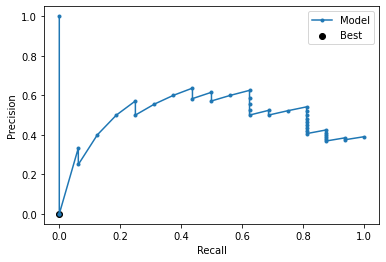

S-TPV Best Threshold=0.773646, F-Score=nan


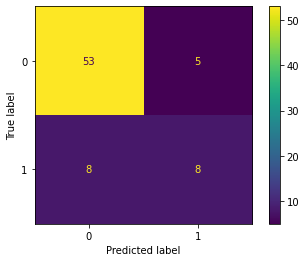

In [27]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8491379310344828


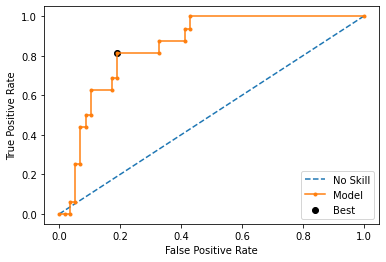

S-E Best Threshold=0.238154, G-Mean=0.811
Accuracy:  0.7972972972972973
Sensitivity:  0.75
Specificity:  0.8103448275862069
PPV:  0.5217391304347826
NPV:  0.9215686274509803


<ipython-input-8-e11804f7b8be>:66: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


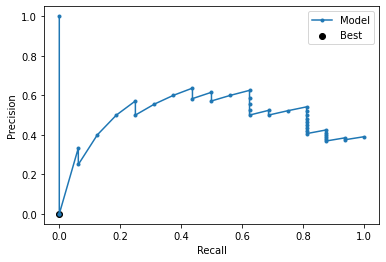

S-TPV Best Threshold=0.773646, F-Score=nan


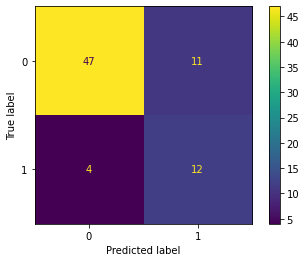

In [37]:
get_metrics(modeldir,directory,grounddir,0.238154)

## Fold 5

In [51]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/ftbigcnnfold4/epoch14"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold5/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold/fold5/pMCI"

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.8088235294117647


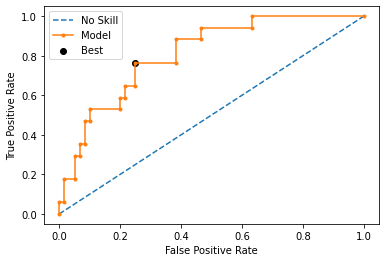

S-E Best Threshold=0.353330, G-Mean=0.757
Accuracy:  0.8051948051948052
Sensitivity:  0.47058823529411764
Specificity:  0.9
PPV:  0.5714285714285714
NPV:  0.8571428571428571


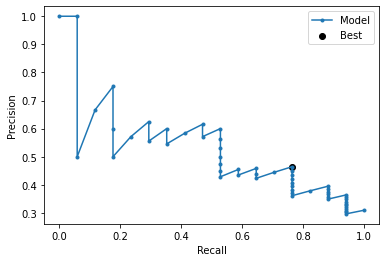

S-TPV Best Threshold=0.353330, F-Score=0.578


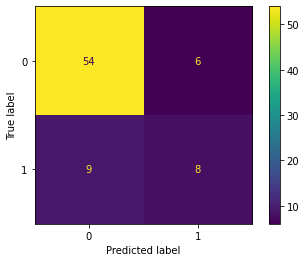

In [29]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.8088235294117647


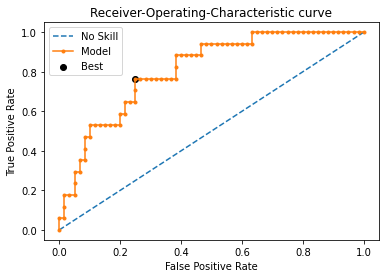

S-E Best Threshold=0.353330, G-Mean=0.757
Accuracy:  0.7402597402597403
Sensitivity:  0.7058823529411765
Specificity:  0.75
PPV:  0.4444444444444444
NPV:  0.9


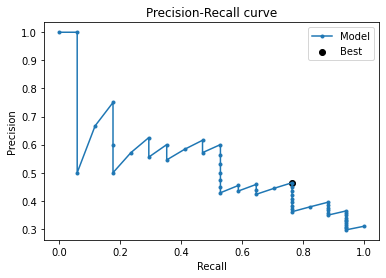

S-TPV Best Threshold=0.353330, F-Score=0.578


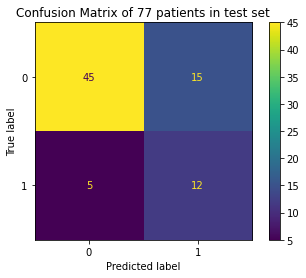

In [52]:
get_metrics(modeldir,directory,grounddir,0.353330)

# MCI to AD, 5 Fold validation. Updated conv, Small CNN

In [5]:
sens=[]
specs=[]
ppvs=[]
npv=[]
aucs=[]

In [25]:
print("Mean Sensitivity: ",(sum(sens)/5))
print("Mean Specificity: ",(sum(specs)/5))
print("Mean PPV: ",(sum(ppvs)/5))
print("Mean NPV: ",(sum(npv)/5))
print("Mean AUC: ",(sum(aucs)/5))

Mean Sensitivity:  0.7835497835497834
Mean Specificity:  0.7713207547169812
Mean PPV:  0.5804360753326271
Mean NPV:  0.9024510939510939
Mean AUC:  0.8282482754523922


## Fold 1

In [6]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn0/epoch16/"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold1/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold1/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8301886792452831


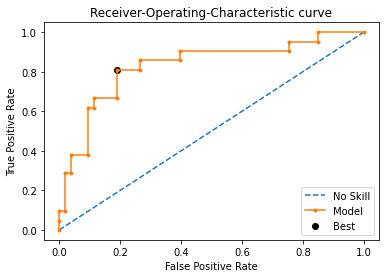

S-E Best Threshold=0.368532, G-Mean=0.810
Accuracy:  0.8243243243243243
Sensitivity:  0.6666666666666666
Specificity:  0.8867924528301887
PPV:  0.7
NPV:  0.8703703703703703


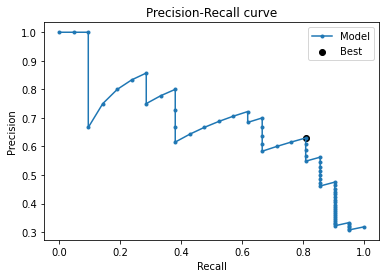

S-TPV Best Threshold=0.368532, F-Score=0.708


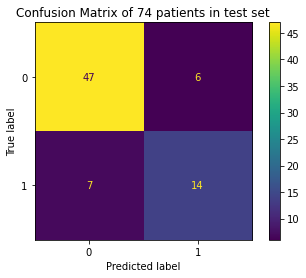

(0.6666666666666666, 0.8867924528301887, 0.7, 0.8703703703703703)

In [9]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8301886792452831


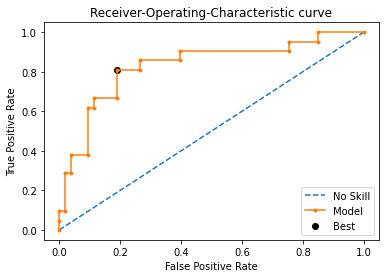

S-E Best Threshold=0.368532, G-Mean=0.810
Accuracy:  0.7972972972972973
Sensitivity:  0.7619047619047619
Specificity:  0.8113207547169812
PPV:  0.6153846153846154
NPV:  0.8958333333333334


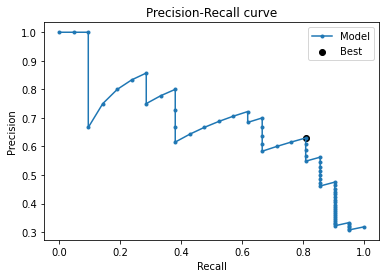

S-TPV Best Threshold=0.368532, F-Score=0.708


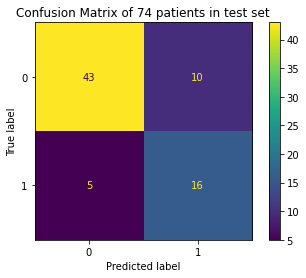

In [7]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.368532)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 2

In [8]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn1/epoch19"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold2/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold2/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8104222821203952


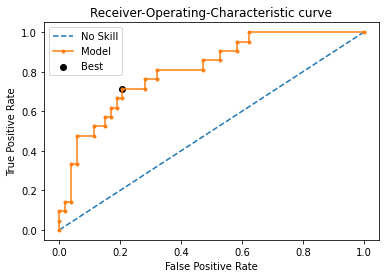

S-E Best Threshold=0.381219, G-Mean=0.752
Accuracy:  0.7702702702702703
Sensitivity:  0.5714285714285714
Specificity:  0.8490566037735849
PPV:  0.6
NPV:  0.8333333333333334


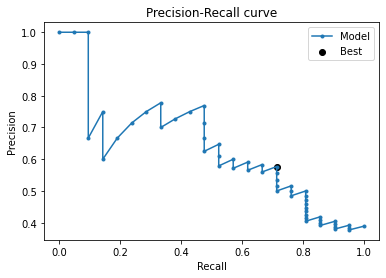

S-TPV Best Threshold=0.381219, F-Score=0.638


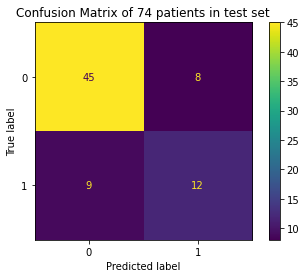

(0.8104222821203952,
 0.5714285714285714,
 0.8490566037735849,
 0.6,
 0.8333333333333334)

In [9]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8104222821203952


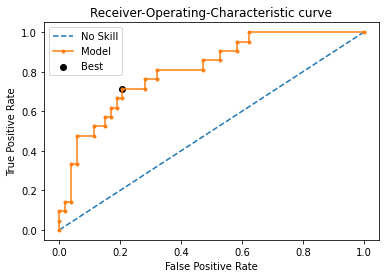

S-E Best Threshold=0.381219, G-Mean=0.752
Accuracy:  0.7567567567567568
Sensitivity:  0.6666666666666666
Specificity:  0.7924528301886793
PPV:  0.56
NPV:  0.8571428571428571


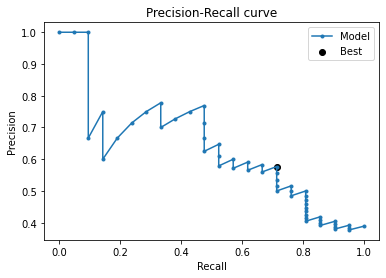

S-TPV Best Threshold=0.381219, F-Score=0.638


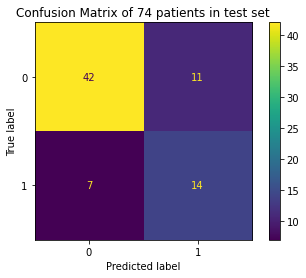

In [10]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.381219)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 3

In [17]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn2/epoch17"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold3/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold3/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8742138364779874


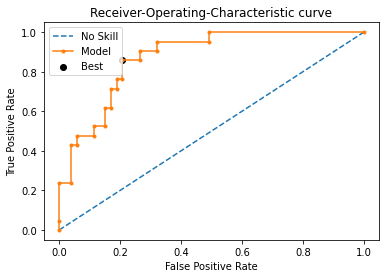

S-E Best Threshold=0.314635, G-Mean=0.824
Accuracy:  0.7837837837837838
Sensitivity:  0.5238095238095238
Specificity:  0.8867924528301887
PPV:  0.6470588235294118
NPV:  0.8245614035087719


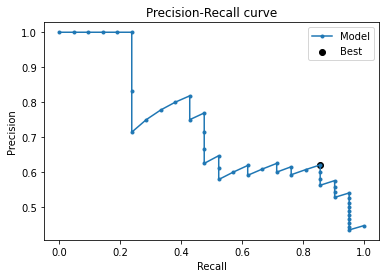

S-TPV Best Threshold=0.314635, F-Score=0.720


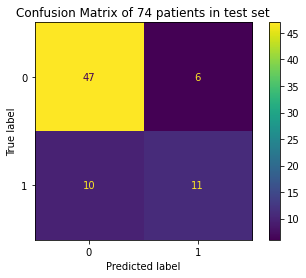

(0.8742138364779874,
 0.5238095238095238,
 0.8867924528301887,
 0.6470588235294118,
 0.8245614035087719)

In [12]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8742138364779874


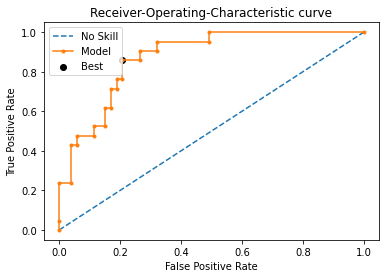

S-E Best Threshold=0.314635, G-Mean=0.824
Accuracy:  0.8108108108108109
Sensitivity:  0.8571428571428571
Specificity:  0.7924528301886793
PPV:  0.6206896551724138
NPV:  0.9333333333333333


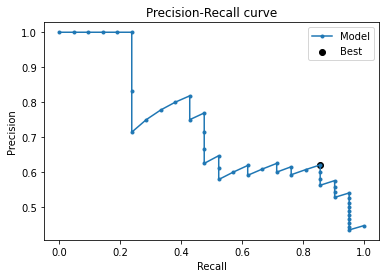

S-TPV Best Threshold=0.314635, F-Score=0.720


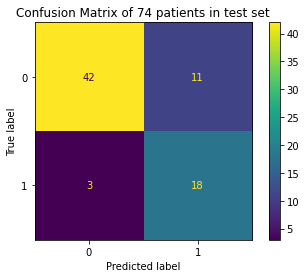

In [18]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.314635)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 4

In [19]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn3/epoch22"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold4/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold4/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8346810422282122


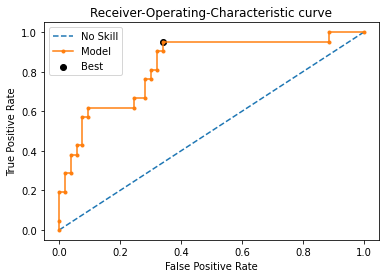

S-E Best Threshold=0.228096, G-Mean=0.793
Accuracy:  0.8108108108108109
Sensitivity:  0.6190476190476191
Specificity:  0.8867924528301887
PPV:  0.6842105263157895
NPV:  0.8545454545454545


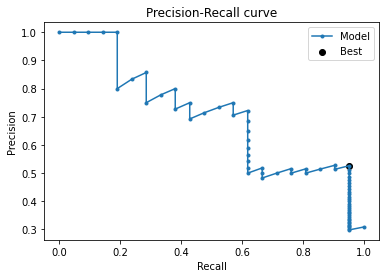

S-TPV Best Threshold=0.228096, F-Score=0.678


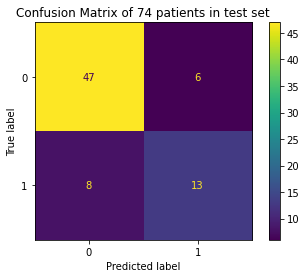

(0.8346810422282122,
 0.6190476190476191,
 0.8867924528301887,
 0.6842105263157895,
 0.8545454545454545)

In [14]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8346810422282122


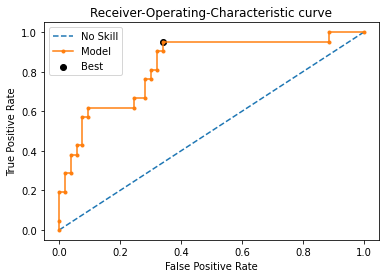

S-E Best Threshold=0.228096, G-Mean=0.793
Accuracy:  0.7297297297297297
Sensitivity:  0.9047619047619048
Specificity:  0.660377358490566
PPV:  0.5135135135135135
NPV:  0.9459459459459459


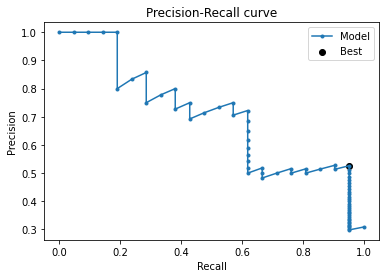

S-TPV Best Threshold=0.228096, F-Score=0.678


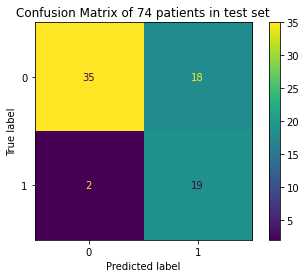

In [20]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.228096)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 5

In [21]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn4/epoch9"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold5/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold5/pMCI"

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.7917355371900827


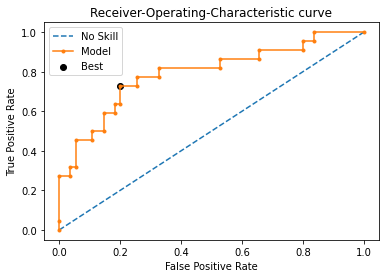

S-E Best Threshold=0.396052, G-Mean=0.763
Accuracy:  0.7662337662337663
Sensitivity:  0.6363636363636364
Specificity:  0.8181818181818182
PPV:  0.5833333333333334
NPV:  0.8490566037735849


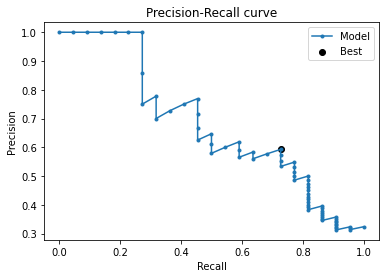

S-TPV Best Threshold=0.396052, F-Score=0.653


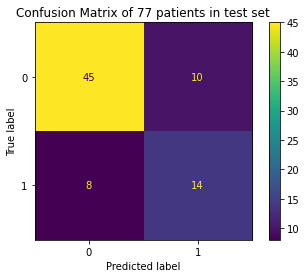

(0.7917355371900827,
 0.6363636363636364,
 0.8181818181818182,
 0.5833333333333334,
 0.8490566037735849)

In [16]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.7917355371900827


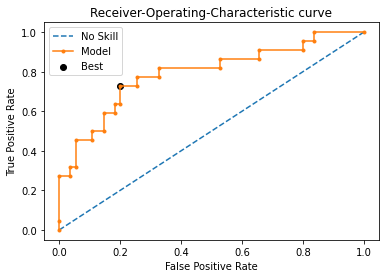

S-E Best Threshold=0.396052, G-Mean=0.763
Accuracy:  0.7792207792207793
Sensitivity:  0.7272727272727273
Specificity:  0.8
PPV:  0.5925925925925926
NPV:  0.88


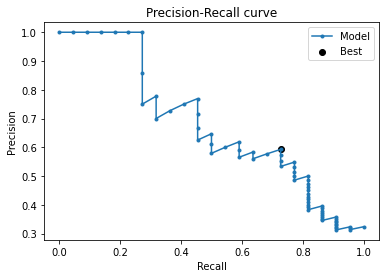

S-TPV Best Threshold=0.396052, F-Score=0.653


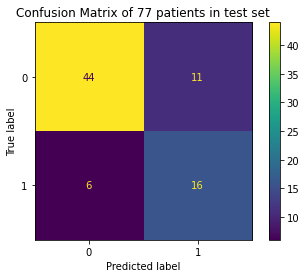

In [22]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.396052)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

# MCI to AD, 5 Fold validation. Updated conv, Replicated Small CNN

In [6]:
sens=[]
specs=[]
ppvs=[]
npv=[]
aucs=[]

In [27]:
print("Mean Sensitivity: ",(sum(sens)/5))
print("Mean Specificity: ",(sum(specs)/5))
print("Mean PPV: ",(sum(ppvs)/5))
print("Mean NPV: ",(sum(npv)/5))
print("Mean AUC: ",(sum(aucs)/5))

Mean Sensitivity:  0.8207792207792208
Mean Specificity:  0.7159519725557462
Mean PPV:  0.550773386243524
Mean NPV:  0.9126175396930115
Mean AUC:  0.8256620109450298


## Fold 1

In [17]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_rep2smallcnn0/epoch29"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold1/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold1/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8661275831087152


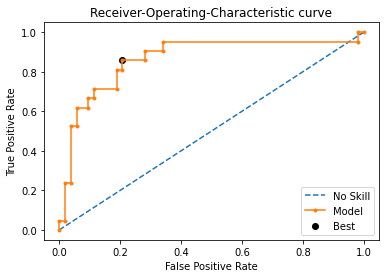

S-E Best Threshold=0.329647, G-Mean=0.824
Accuracy:  0.8243243243243243
Sensitivity:  0.6666666666666666
Specificity:  0.8867924528301887
PPV:  0.7
NPV:  0.8703703703703703


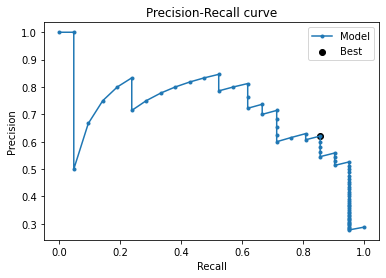

S-TPV Best Threshold=0.329647, F-Score=0.720


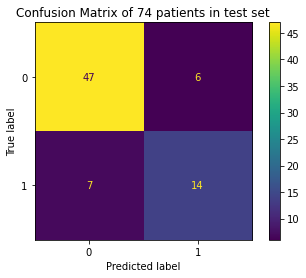

(0.8661275831087152,
 0.6666666666666666,
 0.8867924528301887,
 0.7,
 0.8703703703703703)

In [8]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8661275831087152


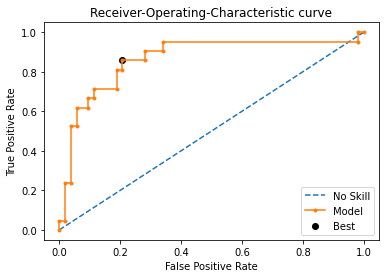

S-E Best Threshold=0.329647, G-Mean=0.824
Accuracy:  0.8108108108108109
Sensitivity:  0.8571428571428571
Specificity:  0.7924528301886793
PPV:  0.6206896551724138
NPV:  0.9333333333333333


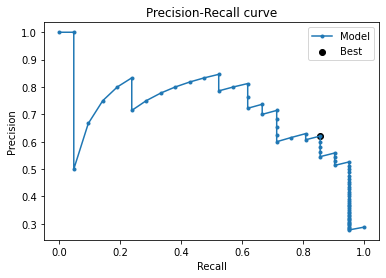

S-TPV Best Threshold=0.329647, F-Score=0.720


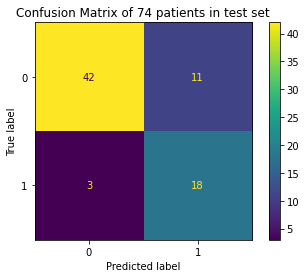

In [18]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.329647)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 2

In [19]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_rep2smallcnn1/epoch25"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold2/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold2/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8427672955974843


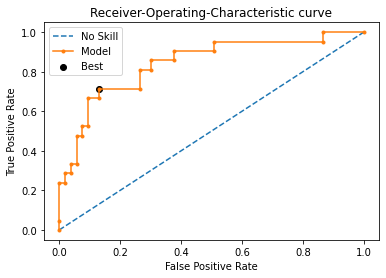

S-E Best Threshold=0.337103, G-Mean=0.787
Accuracy:  0.7702702702702703
Sensitivity:  0.3333333333333333
Specificity:  0.9433962264150944
PPV:  0.7
NPV:  0.78125


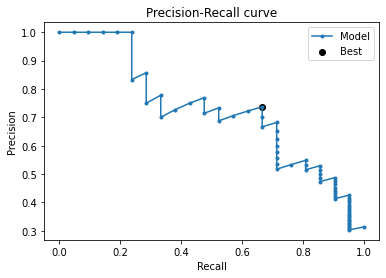

S-TPV Best Threshold=0.379230, F-Score=0.700


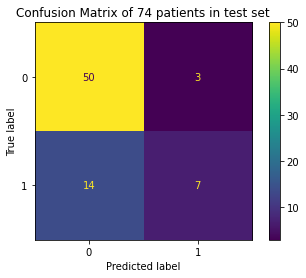

(0.8427672955974843, 0.3333333333333333, 0.9433962264150944, 0.7, 0.78125)

In [10]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8427672955974843


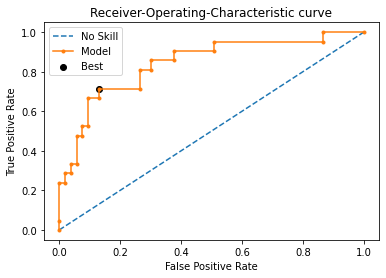

S-E Best Threshold=0.337103, G-Mean=0.787
Accuracy:  0.8108108108108109
Sensitivity:  0.6666666666666666
Specificity:  0.8679245283018868
PPV:  0.6666666666666666
NPV:  0.8679245283018868


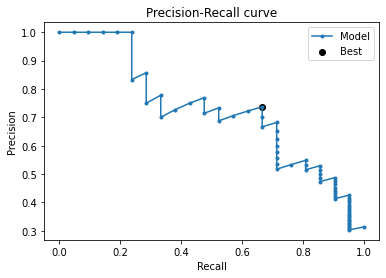

S-TPV Best Threshold=0.379230, F-Score=0.700


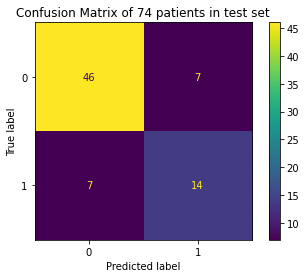

In [20]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.337103)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 3

In [21]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_rep2smallcnn2/epoch2"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold3/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold3/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8373764600179694


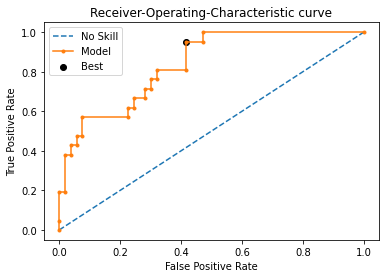

S-E Best Threshold=0.127318, G-Mean=0.746
Accuracy:  0.8108108108108109
Sensitivity:  0.5714285714285714
Specificity:  0.9056603773584906
PPV:  0.7058823529411765
NPV:  0.8421052631578947


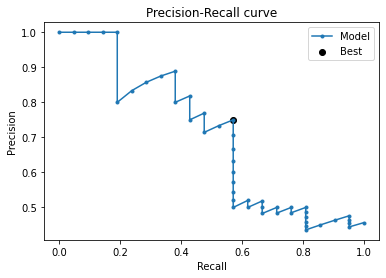

S-TPV Best Threshold=0.508612, F-Score=0.649


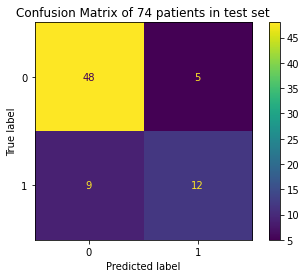

(0.8373764600179694,
 0.5714285714285714,
 0.9056603773584906,
 0.7058823529411765,
 0.8421052631578947)

In [12]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8373764600179694


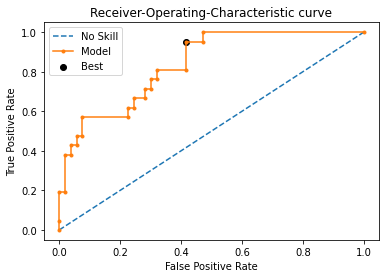

S-E Best Threshold=0.127318, G-Mean=0.746
Accuracy:  0.6756756756756757
Sensitivity:  0.9047619047619048
Specificity:  0.5849056603773585
PPV:  0.4634146341463415
NPV:  0.9393939393939394


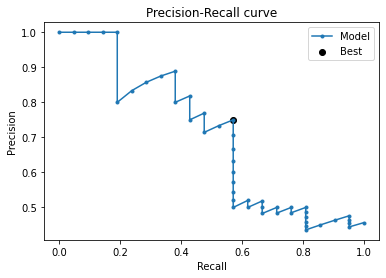

S-TPV Best Threshold=0.508612, F-Score=0.649


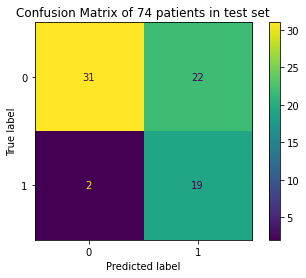

In [22]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.127318)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 4

In [23]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_rep2smallcnn3/epoch10"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold4/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold4/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8274932614555256


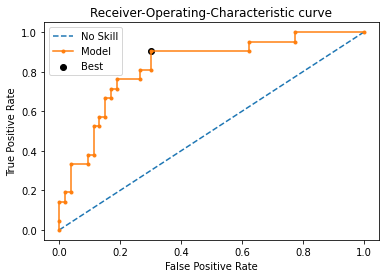

S-E Best Threshold=0.211226, G-Mean=0.795
Accuracy:  0.7702702702702703
Sensitivity:  0.47619047619047616
Specificity:  0.8867924528301887
PPV:  0.625
NPV:  0.8103448275862069


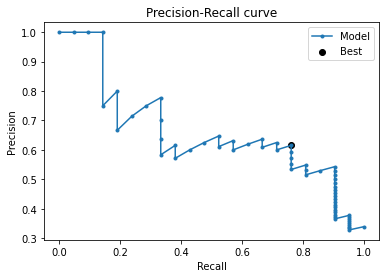

S-TPV Best Threshold=0.294277, F-Score=0.681


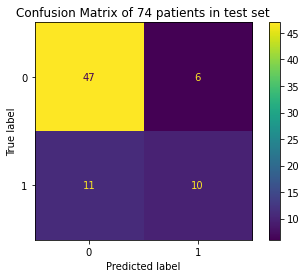

(0.8274932614555256,
 0.47619047619047616,
 0.8867924528301887,
 0.625,
 0.8103448275862069)

In [14]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8274932614555256


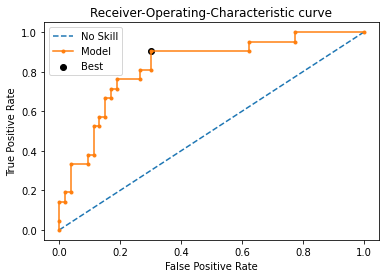

S-E Best Threshold=0.211226, G-Mean=0.795
Accuracy:  0.7432432432432432
Sensitivity:  0.8571428571428571
Specificity:  0.6981132075471698
PPV:  0.5294117647058824
NPV:  0.925


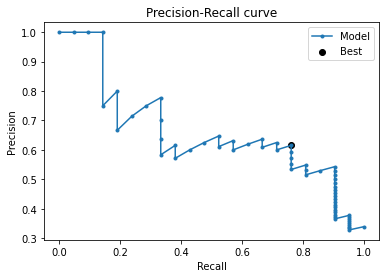

S-TPV Best Threshold=0.294277, F-Score=0.681


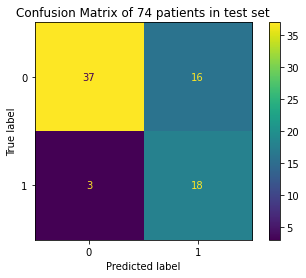

In [24]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.211226)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 5

In [25]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_rep2smallcnn4/epoch8"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold5/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold5/pMCI"

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.7545454545454546


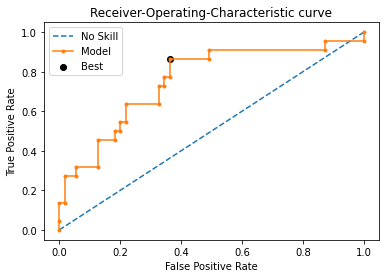

S-E Best Threshold=0.187334, G-Mean=0.741
Accuracy:  0.7272727272727273
Sensitivity:  0.5
Specificity:  0.8181818181818182
PPV:  0.5238095238095238
NPV:  0.8035714285714286


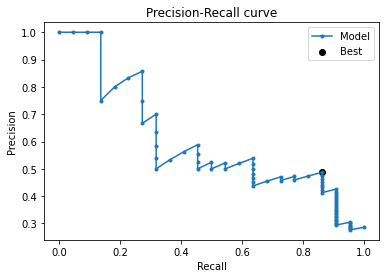

S-TPV Best Threshold=0.187334, F-Score=0.623


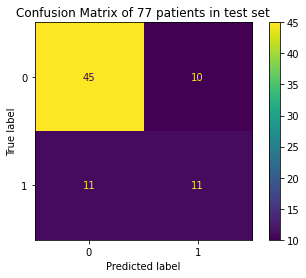

(0.7545454545454546,
 0.5,
 0.8181818181818182,
 0.5238095238095238,
 0.8035714285714286)

In [16]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.7545454545454546


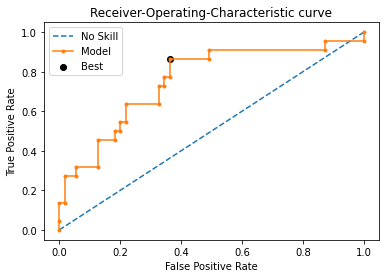

S-E Best Threshold=0.187334, G-Mean=0.741
Accuracy:  0.6883116883116883
Sensitivity:  0.8181818181818182
Specificity:  0.6363636363636364
PPV:  0.47368421052631576
NPV:  0.8974358974358975


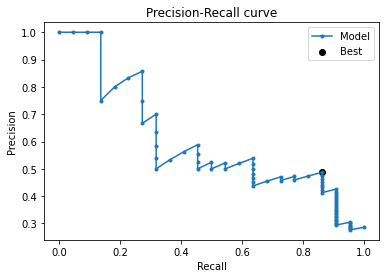

S-TPV Best Threshold=0.187334, F-Score=0.623


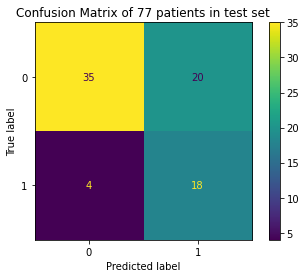

In [26]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.187334)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

# MCI to AD, 5 Fold validation. Updated conv, Ft big CNN

In [16]:
sens=[]
specs=[]
ppvs=[]
npv=[]
aucs=[]

In [27]:
print("Mean Sensitivity: ",(sum(sens)/5))
print("Mean Specificity: ",(sum(specs)/5))
print("Mean PPV: ",(sum(ppvs)/5))
print("Mean NPV: ",(sum(npv)/5))
print("Mean AUC: ",(sum(aucs)/5))

Mean Sensitivity:  0.7173160173160172
Mean Specificity:  0.8389708404802745
Mean PPV:  0.6423731316160101
Mean NPV:  0.8827856987013479
Mean AUC:  0.8504932688809189


## Fold 1

In [17]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/upconv_ftbigcnnfold0/epoch21"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold1/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold1/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8526504941599281


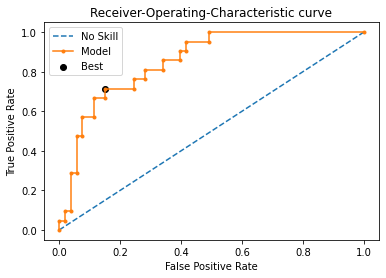

S-E Best Threshold=0.373480, G-Mean=0.779
Accuracy:  0.7972972972972973
Sensitivity:  0.5714285714285714
Specificity:  0.8867924528301887
PPV:  0.6666666666666666
NPV:  0.8392857142857143


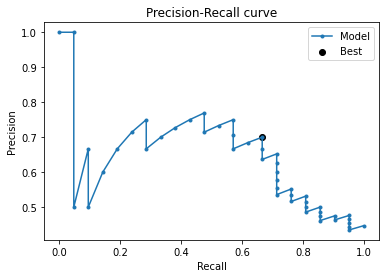

S-TPV Best Threshold=0.472623, F-Score=0.683


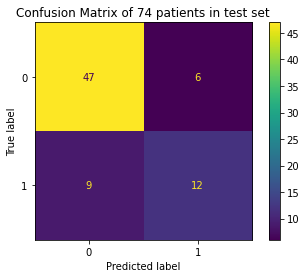

(0.8526504941599281,
 0.5714285714285714,
 0.8867924528301887,
 0.6666666666666666,
 0.8392857142857143)

In [7]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8526504941599281


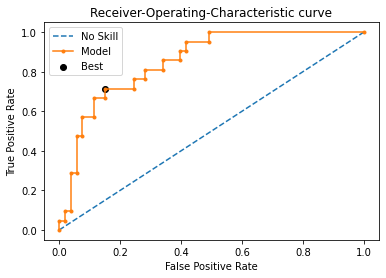

S-E Best Threshold=0.373480, G-Mean=0.779
Accuracy:  0.8108108108108109
Sensitivity:  0.7142857142857143
Specificity:  0.8490566037735849
PPV:  0.6521739130434783
NPV:  0.8823529411764706


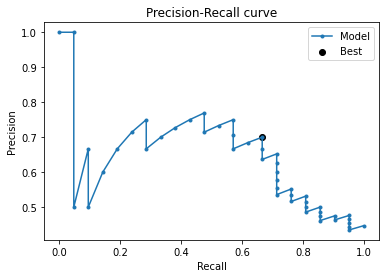

S-TPV Best Threshold=0.472623, F-Score=0.683


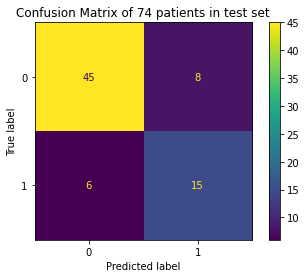

In [18]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.373480)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 2

In [19]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/upconv_ftbigcnnfold1/epoch22"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold2/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold2/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8589398023360287


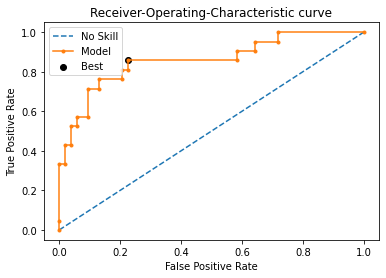

S-E Best Threshold=0.289266, G-Mean=0.814
Accuracy:  0.8243243243243243
Sensitivity:  0.47619047619047616
Specificity:  0.9622641509433962
PPV:  0.8333333333333334
NPV:  0.8225806451612904


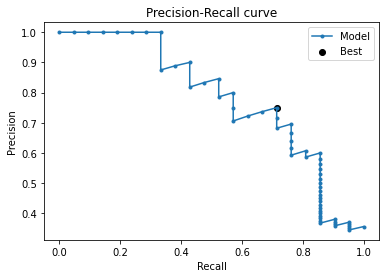

S-TPV Best Threshold=0.365063, F-Score=0.732


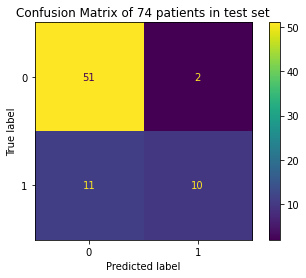

(0.8589398023360287,
 0.47619047619047616,
 0.9622641509433962,
 0.8333333333333334,
 0.8225806451612904)

In [9]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8589398023360287


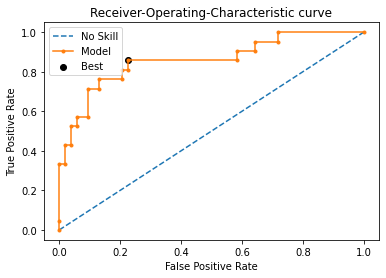

S-E Best Threshold=0.289266, G-Mean=0.814
Accuracy:  0.7837837837837838
Sensitivity:  0.8095238095238095
Specificity:  0.7735849056603774
PPV:  0.5862068965517241
NPV:  0.9111111111111111


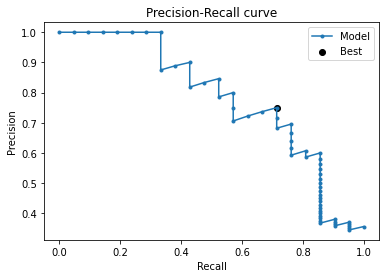

S-TPV Best Threshold=0.365063, F-Score=0.732


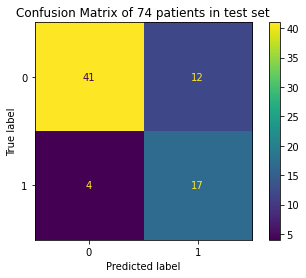

In [20]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.289266)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 3

In [21]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/upconv_ftbigcnnfold2/epoch13"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold3/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold3/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8760107816711591


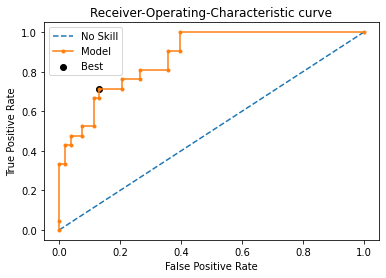

S-E Best Threshold=0.363423, G-Mean=0.787
Accuracy:  0.8108108108108109
Sensitivity:  0.42857142857142855
Specificity:  0.9622641509433962
PPV:  0.8181818181818182
NPV:  0.8095238095238095


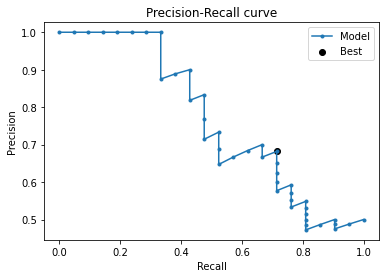

S-TPV Best Threshold=0.363423, F-Score=0.698


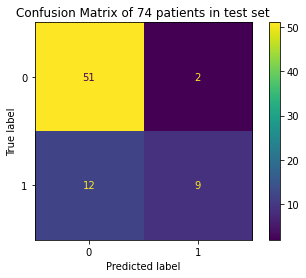

(0.8760107816711591,
 0.42857142857142855,
 0.9622641509433962,
 0.8181818181818182,
 0.8095238095238095)

In [11]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8760107816711591


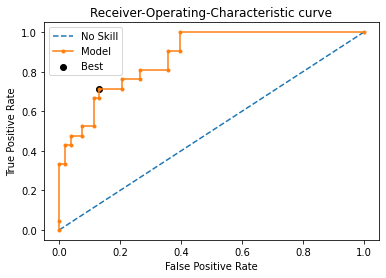

S-E Best Threshold=0.363423, G-Mean=0.787
Accuracy:  0.8243243243243243
Sensitivity:  0.7142857142857143
Specificity:  0.8679245283018868
PPV:  0.6818181818181818
NPV:  0.8846153846153846


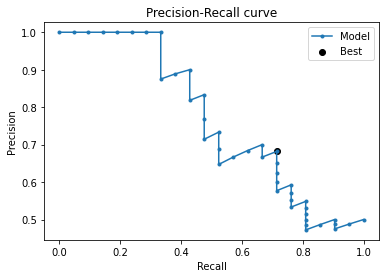

S-TPV Best Threshold=0.363423, F-Score=0.698


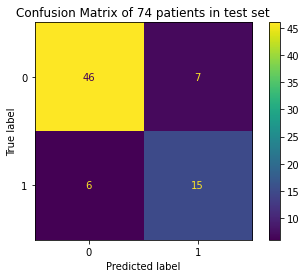

In [22]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.363423)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 4

In [23]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/upconv_ftbigcnnfold3/epoch24"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold4/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold4/pMCI"

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8400718778077269


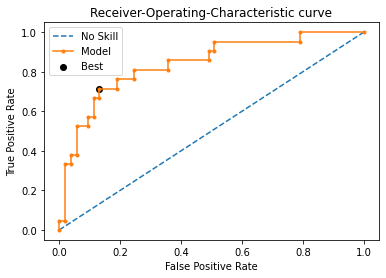

S-E Best Threshold=0.396492, G-Mean=0.787
Accuracy:  0.8108108108108109
Sensitivity:  0.5238095238095238
Specificity:  0.9245283018867925
PPV:  0.7333333333333333
NPV:  0.8305084745762712


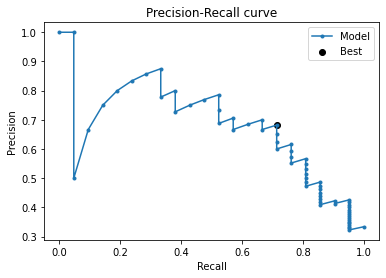

S-TPV Best Threshold=0.396492, F-Score=0.698


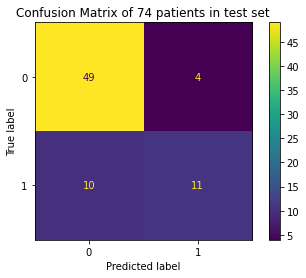

(0.8400718778077269,
 0.5238095238095238,
 0.9245283018867925,
 0.7333333333333333,
 0.8305084745762712)

In [13]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

Area under ROC curve is:  0.8400718778077269


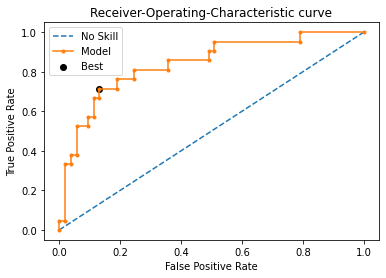

S-E Best Threshold=0.396492, G-Mean=0.787
Accuracy:  0.8108108108108109
Sensitivity:  0.6666666666666666
Specificity:  0.8679245283018868
PPV:  0.6666666666666666
NPV:  0.8679245283018868


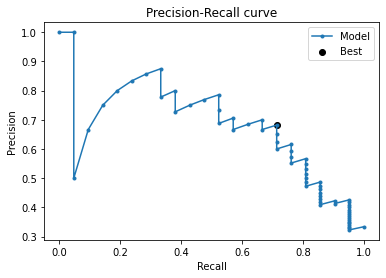

S-TPV Best Threshold=0.396492, F-Score=0.698


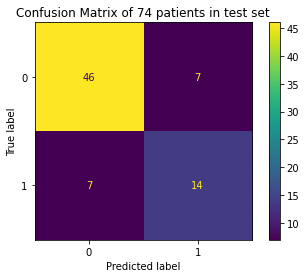

In [24]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.396492)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)

## Fold 5

In [25]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/upconv_ftbigcnnfold4/epoch9"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold5/whole"
grounddir="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold5/pMCI"

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.8247933884297521


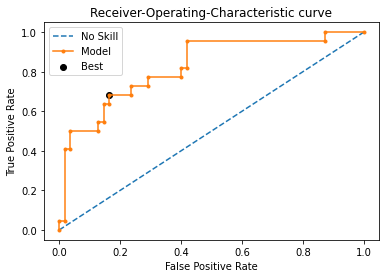

S-E Best Threshold=0.434384, G-Mean=0.755
Accuracy:  0.7792207792207793
Sensitivity:  0.5
Specificity:  0.8909090909090909
PPV:  0.6470588235294118
NPV:  0.8166666666666667


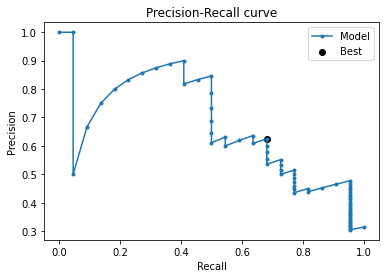

S-TPV Best Threshold=0.434384, F-Score=0.652


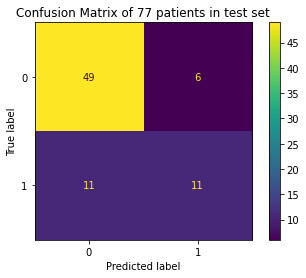

(0.8247933884297521,
 0.5,
 0.8909090909090909,
 0.6470588235294118,
 0.8166666666666667)

In [15]:
get_metrics(modeldir,directory,grounddir)

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

Area under ROC curve is:  0.8247933884297521


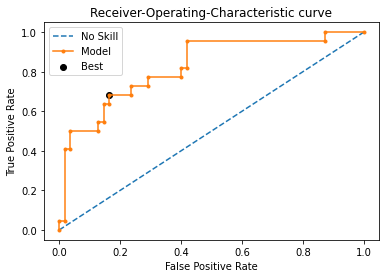

S-E Best Threshold=0.434384, G-Mean=0.755
Accuracy:  0.7922077922077922
Sensitivity:  0.6818181818181818
Specificity:  0.8363636363636363
PPV:  0.625
NPV:  0.8679245283018868


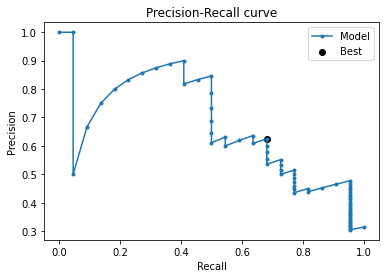

S-TPV Best Threshold=0.434384, F-Score=0.652


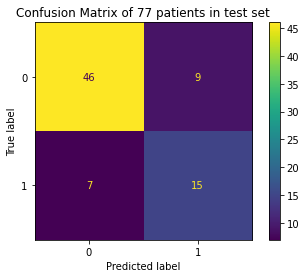

In [26]:
auc,a,b,c,d=get_metrics(modeldir,directory,grounddir,0.434384)
aucs.append(auc)
sens.append(a)
specs.append(b)
ppvs.append(c)
npv.append(d)